# Twitter Fingers == Trigger Fingers: A Look at Gun Violence

## Data Acquisition and Cleaning Part 1:
Data was gathered from one main source, gunviolencearchive.org. Each individual reporting of gun violence comes with sources to prove that it happened, as well as details on the number injured, killed, date, time, and place. The first data acquisition takes these variables, puts them into a dataframe then into csv, as well as finds the source and cleans the links so that they are easily accessible. 

In [1]:
import pandas as pd
import requests
import urllib.request
from bs4 import BeautifulSoup
import re
import numpy as np
import socket
import scipy as sc
import datetime
import matplotlib
import matplotlib.pyplot as plt
import statistics
import datetime

**Functions**

In [7]:
def transform_tables(pd_dataframe):
    # omit the hyperlink column that will be read as NA values
    new_dataframe = pd_dataframe.loc[:,"Incident ID":"# Injured"]
    # rename columns
    new_dataframe = new_dataframe.rename(columns = {"Incident ID": "ID", "Incident Date": "Date", 
                                    "State": "State", "City Or County": "City/County", 
                                    "Address": "Address", "# Killed": "Killed", 
                                    "# Injured": "Injured"})
    return new_dataframe

In [8]:
def save_html(url, path):
    response = requests.get(url)
    with open(path, "wb") as file:
        file.write(response.content)

In [9]:
def get_webpages(soup, year):
    last_webpage_href = soup.find('a', attrs={'title': "Go to last page"})
    last_webpage_path = last_webpage_href.get('href')
    number_of_other_pages = int(re.findall(r'%s(\d+)'%"page=", last_webpage_path)[0])
    if year in range(2014, 2016):
        webpage_paths = ['/reports/mass-shootings/'+ str(year)] # initialize with the first page's path
    else:
        webpage_paths = ['/reports/mass-shooting?year='+ str(year)]
    for page_number in range(1, number_of_other_pages + 1):
        path = re.sub(str(number_of_other_pages), str(page_number), last_webpage_path)
        webpage_paths.append(path)
    return webpage_paths

In [10]:
def get_news_sources(soup):
    news_hrefs = soup.findAll('a', attrs={'href': re.compile("^https://|^http://")})
    news_links = [tag.get('href') for tag in news_hrefs if tag.text == "View Source"] # get all sources listed on a page
    return news_links

In [1]:
def remove_nesting(nested_list):
    return [i for j in nested_list for i in j]

**Acquisition and Cleaning**

In [12]:
# get all pages paths

web_pages_paths = []
for year in range(2014, 2020):
    path = "mass_shooting_html_"+ str(year)
    soup = BeautifulSoup(open(path,'r'), 'html.parser')
    web_pages_paths.append(get_webpages(soup, year)) # including the first

In [13]:
# save first pages html

for year in range(2014, 2020):
    if year in range(2014, 2016):
        first_page_url = "https://www.gunviolencearchive.org/reports/mass-shootings/" + str(year)
    else:
        first_page_url = "https://www.gunviolencearchive.org/reports/mass-shooting?year=" + str(year)
    path = "mass_shooting_html_"+ str(year) 
    save_html(first_page_url, path)

In [ ]:
sources_container = np.arange(2014, 2020, 1).tolist()
for year_index in range(len(sources_container)):
    year = 2014 + year_index
    sources_container[year_index] = []
    page_index = -1
    for path in web_pages_paths[year_index]:
        page_index += 1
        link = "https://www.gunviolencearchive.org" + path
        filename = "mass_shooting_html_"+ str(year) + "_page_" + str(page_index)
        #save_html(link, filename)
        soup = BeautifulSoup(open(filename,'r'), 'html.parser')
        this_page_sources = get_news_sources(soup)
        sources_container[year_index].append(this_page_sources) 
        
sources_container[5][8]

In [ ]:
news_2014 = remove_nesting(sources_container[0])
news_2015 = remove_nesting(sources_container[1])
news_2016 = remove_nesting(sources_container[2])
news_2017 = remove_nesting(sources_container[3])
news_2018 = remove_nesting(sources_container[4])
news_2019 = remove_nesting(sources_container[5])
news_2019[:5]

In [ ]:
# get the report tables

annual_reports = []
for year in range(2014, 2020):
    first_page_url = "https://www.gunviolencearchive.org/reports/mass-shootings/" + str(year)
    csv_file = str(year) + "_mass_shootings.csv"
    this_year_report = pd.read_csv(csv_file)
    cleaned_report = transform_tables(this_year_report)
    annual_reports.append(cleaned_report)
    

In [ ]:
ms_2014 = annual_reports[0]
ms_2015 = annual_reports[1]
ms_2016 = annual_reports[2]
ms_2017 = annual_reports[3]
ms_2018 = annual_reports[4]
ms_2019 = annual_reports[5]

ms_2019.head()

In [ ]:
ms_2014['Source'] = news_2014
ms_2015['Source'] = news_2015
ms_2016['Source'] = news_2016
try:
    ms_2017['Source'] = news_2017
except Exception as e:
    pass
ms_2018['Source'] = news_2018

# ms_2019['Source'] = news_2019 
# gives error since one row does not have a source listed directly

index = news_2019.index("https://www.wcvb.com/article/6-people-shot-outside-of-roxbury-party-police-say/28306883") # index of where it is supposed to be 
news_2019.insert(index, "https://fox2now.com/2019/07/07/north-county-residents-on-edge-after-5-adults-found-dead-in-apartment/")
news_2019 = [news_2019[i] for i in range(len(news_2019)) if news_2019[i] != news_2019[i-1]] 
# in case of re-running the insert code and duplicating

ms_2019['Source'] = news_2019 
ms_2019[:10]

In [ ]:
merged_data = pd.concat([ms_2014, ms_2015, ms_2016, ms_2017, ms_2018, ms_2019])
print(len(merged_data))
merged_data.to_csv(path_or_buf = "complete_project_dataset") # export as csv file

## Data Acquisition Part 2:
The second step of the data acquisition process was to access the sources, and find the article text from each source. This allows us to create a second set of data in a text file for analysis of all words from these articles, "articletext". 

In [ ]:
#reads in complete project data
gunviolencedataset = pd.read_csv("complete_project_dataset")
sourceurl = gunviolencedataset["Source"] #creates a series of just the source urls

The function that takes the source url, goes to the url, reads in the text from that site. The function then writes the text from the "p" tag to a text file, so that it can be accessed afterwards. 

In [ ]:
def getsourcetext(urlseries):
    #initialize beautifulsoup
    soup = BeautifulSoup('''<html>  </html>''', 'html.parser') 
    timeout = 20 #creates a timeout variable w an int
    socket.setdefaulttimeout(timeout) #uses timeout to set the socket timeout
    dictionary = {}
    for k in urlseries: #runs this loop for every entry in the series
        try:
            html = urllib.request.urlopen(url=k) #opens k website
            html = html.read() #reads in website info
            htmlfile = html.decode('utf-8') #decodes the info into a new file
        #need to make exceptions for 404/403/etc
        except Exception as e:
            continue
        else: #what to do after try block works or doesn't work
            singlesoup = BeautifulSoup(htmlfile, 'html.parser') #the variable that holds the data from the article
            full_text = ""
            for n in singlesoup("p"): #finds p tag (the main paragraph of the article)
                full_text += n.get_text(strip=True)#we only want the parts of the article that are from the main paragraph
        dictionary[k] = full_text  
    return dictionary

text_dict_of_1000 = getsourcetext(sourceurl[:1000]) # it takes 1 hour to work the first 1000 urls 

In [ ]:
# Finalized dataframe and save as csv file
full_text_df = pd.DataFrame(list(text_dict_of_1000.items()),
                   columns=['Source', 'Text'])
merged_1000_df = pd.merge(gunviolencedataset, full_text_df, on = "Source")
merged_1000_df.to_csv(path_or_buf = "first_1000_dataset_with_text") 

# get the final version of the data by running this code below 

In [2]:
# Read in the created csv file above
imported_df = pd.read_csv("first_1000_dataset_with_text")
imported_df['Date'] = imported_df['Date'].apply(lambda x: datetime.datetime.strptime(x,"%B %d, %Y"))
imported_df = imported_df.sort_values(by = 'Date')
no_na = imported_df.dropna()

In [3]:
# visually inspection show text with 300 or less characters are not article body
from nltk.tokenize import RegexpTokenizer

n = 0
n1 = 0
m = []
s = 'string'
textseries = no_na["Text"]
eliminationlist = ["©", "Terms of Use", "theTerms", "Terms of Service", "Privacy Policy", "JavaScript", "Policy•CitizensNet"]
tokenizer = RegexpTokenizer('\s+', gaps=True)
indexlist = no_na.index
for string in no_na["Text"]:
    i = indexlist[n]
    i1 = no_na.loc[i].name
    if len(string) < 300:
        string = tokenizer.tokenize(string)
        for word in string:
            if (word in eliminationlist):
                m.append(i)
                break
        n1 += 1    
    n += 1
print(m), print(n), print(n1)
cleaned_imported_df = no_na.drop(labels=m, axis=0) 

[74, 53, 36, 8, 6, 262, 247, 220, 203, 124, 454, 450]
554
31


In [ ]:
data = no_na.loc[no_na["Text"].str.len() > 300]
data = data.iloc[:, 2:11]

print(data.shape)
data.head()

After scraping from the sources of the first 1000 incidents sorted in chronological order, we have all a total of 523 rows. This is due to various reason pertaining to web update: 
- urls did not work gives 404 status code
- article no longer exist
- video content

## Exploratory Analysis:
After obtaining and cleaning the data, we wanted to look at the statistics and visualization of the data gathered. 

In [ ]:
dates = []
num_killed = []
num_injured = []

for row in range(len(data)):
    x = data.iloc[row,1]
    if x in dates:
        num_killed[len(num_killed)-1]+= data.iloc[row,5]
        num_injured[len(num_injured)-1]+= data.iloc[row,6]
    else:
        dates.append(x)
        num_killed.append(data.iloc[row,5])
        num_injured.append(data.iloc[row,6])
        

In [ ]:
plt.plot(dates, num_injured, label = "People Injured")
plt.plot(dates, num_killed, label = "People Killed")

# naming the x axis
plt.xlabel('Dates')
# naming the y axis
plt.ylabel('Number of People')
# giving a title to my graph
plt.title('Number of People Killed or Injured by Guns')
  
# show a legend on the plot
plt.legend()
  
# function to show the plot
plt.show()

In [ ]:
d = {'statistic' : ['mean','median','mode','std','min','max'], 
     'Number Killed' : [np.mean(num_killed),np.median(num_killed),statistics.mode(num_killed),np.std(num_killed),min(num_killed),max(num_killed)],
    'Number Injured' : [np.mean(num_injured),np.median(num_injured),statistics.mode(num_injured),np.std(num_injured),min(num_injured),max(num_injured)]
    }

stats_of_the_data = pd.DataFrame(data = d)
print(stats_of_the_data)

In [ ]:
words = data["Text"].str.split()
words = words.map(lambda x: len(x))

fig, axs = plt.subplots(1, 2, figsize=(15, 5))
axs[0].plot(data["Date"], words)
axs[0].set_title("Length of Article by Date")
axs[1].hist(words, bins = 50)
axs[1].set_title("Length of Article Histogram")
plt.show()

The length of the article seems to correlate with the trend in the number of injured or killed victims.

In [ ]:
from textblob import TextBlob # simple library; sutiable for exploratory analysis
def polarity(text):
    return TextBlob(text).sentiment.polarity 

polarity_score = data['Text'].apply(lambda x : polarity(x))

fig, axs = plt.subplots(1, 2, figsize=(15, 5))
axs[0].plot(data["Date"], polarity_score)
axs[0].set_title("Polarity Score by Date")
axs[1].hist(polarity_score)
axs[1].set_title("Polarity Score Histogram")
plt.show()

The polarity score distribution determined by TextBlob.sentiment.polarity is centered at 0 with a small deviation. The articles are mostly neutral.

## Analysis Method Outlines: N-grams and Sentiment Analysis Classification

**NLP Analysis:** We wanted to use Natural Language Processing to inspect the relations of words in the articles we find, in the hopes that we can relate fequency of word use and the context that these fequently used words are in to the increase of gun violence in America. To start this the article text extracted must be tokenized (sorted into words), remove the words and punctuation that are too common to be useful, and assess the frequency of the cleaned words. Then ngrams are created of these words to assess the context that the frequent words come in. 

What remains to be done is connect these results to collective meaning about the articles, and how that relates to gun violence. 

In [89]:
import nltk
from nltk import FreqDist
from nltk.tokenize import RegexpTokenizer
from nltk.corpus import stopwords
import codecs
from nltk.tokenize import RegexpTokenizer
# make list of stopwords, numbers, and punctuation
stopwords = nltk.corpus.stopwords.words('english')
capstopwords = [w.title() for w in stopwords]
numbers = ["one", "two", "three", "four", "five", "six", "seven", "eight", "nine", "zero", ",", "'", "-", "said", "2021march"]
stopwords.extend(capstopwords)
stopwords.extend(numbers)

In [90]:
# keywordstuple_list = []
# for article in data["Text"]:
#     tokenizer = RegexpTokenizer(r'\w+')
#     articletext = tokenizer.tokenize(article)
#     articletext = [word.lower() for word in articletext if word not in stopwords]
#     frequency_dist = FreqDist(articletext)
#     keywordstuple = frequency_dist.most_common(10)
#     keywordstuple_list.append(list(keywordstuple))

# keywordstuple_list 

In [91]:
def uncouplevector(vector):
    uncoupledvector = []
    for ftuple in vector:
        t1 = ftuple[0]
        t2 = int(ftuple[1])
        uncoupledvector.append(t1)
        uncoupledvector.append(t2)
    return uncoupledvector

def averageuncv(vector, N):
    n = 1
    for element in vector:
        if type(element) == type(0):
            element = element/N
            vector[n] = element
            n += 2
    return vector

def addtokeyworddf(vector, row):
    keyrow = keywordDF.iloc[row]
    n = 0
    for element in vector:
        keyrow[n] = element
        n += 1
    keywordDF.iloc[row] = keyrow

# Unigram (one-word) analysis

Using a tokenizer, we break up the text in each article to get the important words. Then the frequency of the word in the article is given, its then standardized by the total article words. This is added to a dataframe "keywordDF" for computation.

In [92]:
l = cleaned_imported_df.shape
keywordDF = np.zeros((l[0], 20))
keywordDF = pd.DataFrame(keywordDF)
n=0
m=0
vsum=[]
tokenizer = RegexpTokenizer('\s+', gaps=True)
for index, row in cleaned_imported_df.iterrows():
    tokenizedarticle = tokenizer.tokenize(row["Text"])
    articletext = [word.lower() for word in tokenizedarticle if word not in stopwords]
    frequencydist = FreqDist(articletext)
    wordsN = frequencydist.N()
    keywords = frequencydist.most_common(10)
    keywordvector = uncouplevector(keywords)
    averagedkeywords = averageuncv(keywordvector, wordsN)
    addtokeyworddf(averagedkeywords, n)
    n += 1

<ipython-input-91-e28d21a11202>:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  keyrow[n] = element


In [93]:
print(keywordDF.head())
secondmostcommondwords = keywordDF[2]
secondmostcommondwords.value_counts()
index1 = cleaned_imported_df.index
labels = ['ID', 'Date', 'State', 'City/County', 'Address', 'Killed', 'Injured']
interimdf = cleaned_imported_df[labels]
#unigram frequencies
keywordlabels = ["OneMCW", "OneMCWFreq", "TwoMCW", "TwoMCWFreq", "ThreeMCW", "ThreeMCWFreq", "FourMCW", "FourMCWFreq", "FiveMCW", "FiveMCWFreq", "SixMCW", "SixMCWFreq", "SevenMCW", "SevenMCWFreq", "EightMCW", "EightMCWFreq", "NineMCW", "NineMCWFreq", "TenMCW", "TenMCWFreq"]
keywordDF.columns = keywordlabels
keywordDF.index = index1
unigramfreq = pd.concat([interimdf, keywordDF], axis=1)
unigramfreq.to_csv("UnigramFrequencies")

police         55
shooting       36
shot           23
people         13
man            11
               ..
friday          1
pit             1
transported     1
boy             1
email           1
Name: 2, Length: 294, dtype: int64

In [94]:
#create a graph/track the most common words (5) in article over time(by month?), what do we see(?)

import pandas as pd
import requests
import urllib.request
from bs4 import BeautifulSoup
import re
import numpy as np
import socket
import scipy as sc
import datetime
import matplotlib
import matplotlib.pyplot as plt
import statistics
import datetime

In [95]:
unigram = pd.read_csv('UnigramFrequencies')

words=[]
frequencies = []
MCW = []

def most_frequent(List):
    return max(set(List), key = List.count)

for x in range(5):
    for row in range(len(unigram)):
        for column in [8,10,12,14,16,18,20,22,24,26]:
            word = unigram.iloc[row,column]
            if word not in MCW:
                words.append(word)
            
    MCW.append(most_frequent(words))
    words=[]
    
print(MCW)

['police', 'shooting', 'shot', 'people', 'man']


In [96]:
dates = []
police_freq = []
shooting_freq = []
shot_freq = []
people_freq = []
man_freq = []
freq = [police_freq,shooting_freq,shot_freq,people_freq,man_freq]

for row in range(len(unigram)):
        for column in [8,10,12,14,16,18,20,22,24,26]:
            x = datetime.datetime.strptime(unigram.iloc[row,2],"%Y-%m-%d")
            word = unigram.iloc[row,column]
            if x not in dates:
                dates.append(x)
                for i in range(5):
                    if word==MCW[i]:
                        freq[i].append(unigram.iloc[row,(column+1)])
                    else:
                        freq[i].append(0)
            else:
                for i in range(5):
                    if word==MCW[i]:
                        freq[i][len(freq[i])-1]+=unigram.iloc[row,(column+1)]

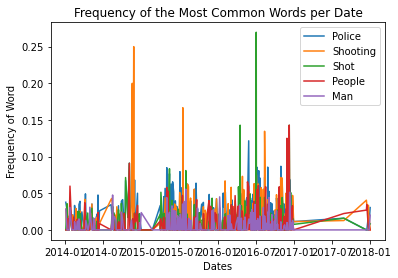

In [97]:
plt.plot(dates, police_freq, label = "Police")
plt.plot(dates, shooting_freq, label = "Shooting")
plt.plot(dates, shot_freq, label = "Shot")
plt.plot(dates, people_freq, label = "People")
plt.plot(dates, man_freq, label = "Man")

# naming the x axis
plt.xlabel('Dates')
# naming the y axis
plt.ylabel('Frequency of Word')
# giving a title to my graph
plt.title('Frequency of the Most Common Words per Date')
  
# show a legend on the plot
plt.legend()
  
# function to show the plot
plt.show()

This graph represents the frequency of a word in its article, when the article was published.

# Bigram Analysis

Bigrams were created of each article text in a similar way to the unigram analysis, the frequency was created by dividing the number of appearances of a bigram by the total number of bigrams possible in the article. Saving the 10 most common bigrams per article, a dataframe "bigramDF" was constructed.

In [99]:
from nltk.classify.util import apply_features, accuracy as eval_accuracy
from nltk.collocations import BigramCollocationFinder
from nltk.metrics import (
    BigramAssocMeasures,
    precision as eval_precision,
    recall as eval_recall,
    f_measure as eval_f_measure,
)
bgm    = nltk.collocations.BigramAssocMeasures()
from nltk.probability import FreqDist

In [100]:
#cut up the big function
#tokenize the data
def tokenizerow(row):
    from nltk.tokenize.treebank import TreebankWordTokenizer
    from nltk.corpus import stopwords
    stopwords = nltk.corpus.stopwords.words('english')
    capstopwords = [w.title() for w in stopwords]
    numbers = ["one", "two", "three", "four", "five", "six", "seven", "eight", "©", "nine", "zero", '``', "article.submitcopyright","''", ".", ",", ":", "'", "-", ")", "(", "said", "2021march"]
    stopwords.extend(capstopwords)
    stopwords.extend(numbers)
    tokenizer = TreebankWordTokenizer()
    tokenizedarticle = tokenizer.tokenize(row)
    #figure out how to strip of punctuation 
    #figure out how to strip of numbers
    tokenizedarticle = [word.lower() for word in tokenizedarticle if word not in stopwords]
    return tokenizedarticle

#put most common bigrams into a new dataframe (bigramDF)
def bigramfreq(bigrams):
    bigramfreq = FreqDist(bigrams)
    top10bigrams = FreqDist(bigrams).most_common(10)
    bigramN = bigramfreq.N()
    return top10bigrams, bigramN

#compute likelihood score
#score = bigrams.score_ngrams(bgm.likelihood_ratio)
        #likelihoodscores.append(score)
def uncouplevector(vector):
    uncoupledvector = []
    for ftuple in vector:
        t1 = ftuple[0]
        t2 = int(ftuple[1])
        uncoupledvector.append(t1)
        uncoupledvector.append(t2)
    return uncoupledvector   

def vectortodf(v, dataframe, row, N):
    extuple = ('s','t')
    n = 0
    n1 = 1
    krow = dataframe.loc[row]
    for item in v:
        if type(item) == type(extuple):
            krow[n] = item
            n += 2
        else:
            krow[n1] = (item/N) * 100
            n1 += 2
    dataframe.iloc[row] = krow
    #print(row, "row added to dataframe")
    return 

#add every uncoupled vector to a new row in a dataframe
l=cleaned_imported_df.shape
bigramDF = np.zeros((l[0], 20))
bigramDF = pd.DataFrame(bigramDF)
n=0
for row in cleaned_imported_df["Text"]:
    tokenizedrow = tokenizerow(row)
    bg = list(nltk.bigrams(tokenizedrow))
    bigramfreqvector, bgN = bigramfreq(bg)
    v = uncouplevector(bigramfreqvector)
    vectortodf(v, bigramDF, n, bgN)
    n+=1
bigramDF.head()

<ipython-input-100-83cc8a4950f4>:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  krow[n] = item
<ipython-input-100-83cc8a4950f4>:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  krow[n1] = (item/N) * 100


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
0,"(east, erie)",1.869159,"(upmc, hamot)",1.869159,"(shots, fired)",0.934579,"(fired, around)",0.934579,"(around, 1)",0.934579,"(1, a.m.)",0.934579,"(a.m., sunday)",0.934579,"(sunday, morning)",0.934579,"(morning, east)",0.934579,"(erie, neighborhood)",0.934579
1,"(jackson, police)",1.801802,"(near, m-bar)",1.801802,"(man, shot)",1.801802,"(jackson, ms)",0.900901,"(ms, mississippi)",0.900901,"(mississippi, news)",0.900901,"(news, jackson)",0.900901,"(police, investing)",0.900901,"(investing, shootings)",0.900901,"(shootings, early)",0.900901
2,"(police, arrested)",1.463415,"(arrested, 15-year-old)",0.975610,"(shooting, people)",0.975610,"(benchwarmer, sports)",0.975610,"(sports, club)",0.975610,"(early, sunday)",0.975610,"(according, press)",0.975610,"(press, release.)",0.975610,"(shooting, suspect)",0.975610,"(fight, club)",0.975610
3,"(ford, heights)",1.639344,"(cook, county)",1.639344,"(according, cook)",1.639344,"(p.m., wednesday)",1.639344,"(16-year-old, boy)",0.819672,"(boy, charged)",0.819672,"(charged, killing)",0.819672,"(killing, 17-year-old)",0.819672,"(17-year-old, ford)",0.819672,"(heights, following)",0.819672
4,"(los, angeles)",1.554404,"(tuesday, evening)",1.036269,"(angeles, police)",1.036269,"(ktlaby, melissa)",0.518135,"(melissa, pamerfour)",0.518135,"(pamerfour, people)",0.518135,"(people, wounded)",0.518135,"(wounded, shooting)",0.518135,"(shooting, south)",0.518135,"(south, los)",0.518135


In [101]:
#add death/injury data to article data
cleaned_imported_df
index1 = cleaned_imported_df.index
labels = ['ID', 'Date', 'State', 'City/County', 'Address', 'Killed', 'Injured']
interimdf = cleaned_imported_df[labels]
#bigram frequencies
keywordlabels = ["OneMFB", "OneMFBFreq", "TwoMFB", "TwoMFBFreq", "ThreeMFB", "ThreeMFBFreq", "FourMFB", "FourMFBFreq", "FiveMFB", "FiveMFBFreq", "SixMFB", "SixMFBFreq", "SevenMFB", "SevenMFBFreq", "EightMFB", "EightMFBFreq", "NineMFB", "NineMFBFreq", "TenMFB", "TenMFBFreq"]
bigramDF.columns = keywordlabels
bigramDF.index = index1
bigramfreq = pd.concat([bigramDF, interimdf], axis=1) 
bigramfreq.to_csv("BigramFrequencies")
#need to organize by date

In [102]:
import pandas as pd
import requests
import urllib.request
from bs4 import BeautifulSoup
import re
import numpy as np
import socket
import scipy as sc
import datetime
import matplotlib
import matplotlib.pyplot as plt
import statistics
import datetime

In [103]:
bigram = pd.read_csv('BigramFrequencies')

words=[]
frequencies = []
MCB = []

def most_frequent(List):
    return max(set(List), key = List.count)

for x in range(6):
    for row in range(len(bigram)):
        for column in [1,3,5,7,9,11,13,15,17,19]:
            word = bigram.iloc[row,column]
            if word not in MCB:
                words.append(word)
            
    MCB.append(most_frequent(words))
    words=[]
    
print(MCB)

['0.0', "('people', 'shot')", "('man', 'shot')", "('four', 'people')", '(\'sheriff\', "\'s")', "('los', 'angeles')"]


In [104]:
dates = []
peopleshot_freq = []
manshot_freq = []
policesaid_freq = []
fourpeople_freq = []
losangeles_freq = []
freq = [peopleshot_freq,manshot_freq,policesaid_freq,fourpeople_freq,losangeles_freq]

for row in range(len(bigram)):
        for column in [1,3,5,7,9,11,13,15,17,19]:
            x = datetime.datetime.strptime(bigram.iloc[row,22],"%Y-%m-%d")
            word = bigram.iloc[row,column]
            if x not in dates:
                dates.append(x)
                for i in range(5):
                    if word==MCB[i+1]:
                        freq[i].append(bigram.iloc[row,(column+1)])
                    else:
                        freq[i].append(0)
            else:
                for i in range(5):
                    if word==MCB[i+1]:
                        freq[i][len(freq[i])-1]+=bigram.iloc[row,(column+1)]    

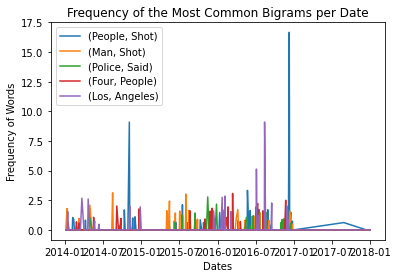

In [105]:
plt.plot(dates, peopleshot_freq, label = "(People, Shot)")
plt.plot(dates, manshot_freq, label = "(Man, Shot)")
plt.plot(dates, policesaid_freq, label = "(Police, Said)")
plt.plot(dates, fourpeople_freq, label = "(Four, People)")
plt.plot(dates, losangeles_freq, label = "(Los, Angeles)")

# naming the x axis
plt.xlabel('Dates')
# naming the y axis
plt.ylabel('Frequency of Words')
# giving a title to my graph
plt.title('Frequency of the Most Common Bigrams per Date')
  
# show a legend on the plot
plt.legend()
  
# function to show the plot
plt.show()

This graph shows the frequency of a bigram per article, when the article was published. 

# Multiple Linear Regression

Its not quite enough to have the frequencies of words in an article, they have to be tested for relationships with the gun violence data that was collected. 

In [77]:
import statsmodels.formula.api as sm

In [52]:
singlewordfreq = pd.read_csv("UnigramFrequencies")
print(pd.plotting.scatter_matrix(singlewordfreq, figsize=(15, 15), diagonal='hist'))
print(singlewordfreq.corr())
#
unigramkilledmlrols = sm.ols(formula="Killed ~ OneMCWFreq + TwoMCWFreq + ThreeMCWFreq + FourMCWFreq + FiveMCWFreq + SixMCWFreq + SevenMCWFreq + EightMCWFreq + NineMCWFreq + TenMCWFreq", data=singlewordfreq).fit()
unigraminjureddmlrols = sm.ols(formula="Injured ~ OneMCWFreq + TwoMCWFreq + ThreeMCWFreq + FourMCWFreq + FiveMCWFreq + SixMCWFreq + SevenMCWFreq + EightMCWFreq + NineMCWFreq + TenMCWFreq", data=singlewordfreq).fit()
unigramkilledmlrols.summary(), unigraminjuredmlrols.summary()
#multivariable analysis shows that there is very weak, positive correlation between the word frequencies and the killed and injured
#slightly greater r-squared when injured is added to the linear combination of killed, and vice versa
# injured and killed have medium (.5 of [-1,1]) positive correlation

              Unnamed: 0        ID    Killed   Injured  OneMCWFreq  \
Unnamed: 0      1.000000  0.750875  0.044193  0.011278   -0.002742   
ID              0.750875  1.000000  0.030075  0.005011   -0.000561   
Killed          0.044193  0.030075  1.000000  0.511368   -0.089005   
Injured         0.011278  0.005011  0.511368  1.000000    0.000336   
OneMCWFreq     -0.002742 -0.000561 -0.089005  0.000336    1.000000   
TwoMCWFreq     -0.015749 -0.017030 -0.089055  0.019478    0.941309   
ThreeMCWFreq   -0.024161 -0.028250 -0.076190  0.018563    0.918251   
FourMCWFreq    -0.021056 -0.023524 -0.071812  0.022325    0.910156   
FiveMCWFreq    -0.008404 -0.015094 -0.067380 -0.016394    0.704995   
SixMCWFreq      0.004576  0.012957 -0.051939 -0.008340    0.595274   
SevenMCWFreq    0.044401  0.053087 -0.037664 -0.013744    0.470646   
EightMCWFreq   -0.002501  0.023175 -0.076746 -0.002838    0.315679   
NineMCWFreq    -0.008482 -0.008373 -0.068989 -0.009974    0.268435   
TenMCWFreq      0.00

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                Injured   R-squared:                       0.280
Model:                            OLS   Adj. R-squared:                  0.265
Method:                 Least Squares   F-statistic:                     18.75
Date:                Sun, 25 Apr 2021   Prob (F-statistic):           7.98e-32
Time:                        14:42:02   Log-Likelihood:                -1284.9
No. Observations:                 542   AIC:                             2594.
Df Residuals:                     530   BIC:                             2645.
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
================================================================================
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept        3.5967      0.251     14.321      0.000       3.103       4.090
Killed           0.6218      0.044     14.018      0.000       0.535       0.709
OneMCWFreq     -14.4085     12.743     -1.131      0.259     -39.442      10.625
TwoMCWFreq      39.3418     23.473      1.676      0.094      -6.769      85.452
ThreeMCWFreq   -28.2382     37.523     -0.753      0.452    -101.951      45.474
FourMCWFreq     16.5262     34.198      0.483      0.629     -50.653      83.706
FiveMCWFreq    -12.1006     12.001     -1.008      0.314     -35.677      11.475
SixMCWFreq       6.0917     14.426      0.422      0.673     -22.247      34.430
SevenMCWFreq   -15.3444     14.878     -1.031      0.303     -44.572      13.883
EightMCWFreq    23.7231     21.661      1.095      0.274     -18.829      66.276
NineMCWFreq     36.8310     28.863      1.276      0.202     -19.868      93.530
TenMCWFreq     -55.4778     24.806     -2.236      0.026    -104.208      -6.748
==============================================================================
Omnibus:                      175.397   Durbin-Watson:                   1.944
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1890.788
Skew:                           1.091   Prob(JB):                         0.00
Kurtosis:                      11.886   Cond. No.                     1.20e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.2e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [76]:
bigramfreqdf =  pd.read_csv("BigramFrequencies")
bigramfreqdf = bigramfreqdf[['Killed', 'Injured', 'OneMFBFreq', 'TwoMFBFreq', 'ThreeMFBFreq', 'FourMFBFreq',
       'FiveMFBFreq', 'SixMFBFreq', 'SevenMFBFreq', 'EightMFBFreq',
       'NineMFBFreq', 'TenMFBFreq']]
print(pd.plotting.scatter_matrix(bigramfreqdf, figsize=(15, 15), diagonal='hist'))
print(bigramfreqdf.corr())

bigramkilledmlrols = sm.ols(formula="Killed ~ OneMFBFreq + TwoMFBFreq + ThreeMFBFreq + FourMFBFreq + FiveMFBFreq + SixMFBFreq + SevenMFBFreq + EightMFBFreq + NineMFBFreq + TenMFBFreq", data=bigramfreqdf).fit()
bigraminjureddmlrols = sm.ols(formula="Injured ~ OneMFBFreq + TwoMFBFreq + ThreeMFBFreq + FourMFBFreq + FiveMFBFreq + SixMFBFreq + SevenMFBFreq + EightMFBFreq + NineMFBFreq + TenMFBFreq", data=bigramfreqdf).fit()
bigramkilledmlrols.summary(), bigraminjureddmlrols.summary()

(<class 'statsmodels.iolib.summary.Summary'>
 """
                             OLS Regression Results                            
 Dep. Variable:                 Killed   R-squared:                       0.017
 Model:                            OLS   Adj. R-squared:                 -0.001
 Method:                 Least Squares   F-statistic:                    0.9379
 Date:                Sun, 25 Apr 2021   Prob (F-statistic):              0.498
 Time:                        17:01:02   Log-Likelihood:                -1273.4
 No. Observations:                 542   AIC:                             2569.
 Df Residuals:                     531   BIC:                             2616.
 Df Model:                          10                                         
 Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
 -------------------------------------------------------------------

We see in bigrams that there is little to no correlation between frequencies of bigrams in an article and the amount of people injured or killed. Multiple linear regression shows a very low r-squared score for both kiled (.017) and for injured (.010) which indicates that they are not correlated. 

# Sentiment Analysis

**Sentiment Analysis:** Our second kind of analysis for the article is going to be sentiment analysis classification. We created a classification model that trains on a library of tweets that are rated from 0 through 4 on a negative-positive scale. The tweet is vectorized into features and its rating. 

In [2]:
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from collections import Counter
import nltk
from nltk.tokenize import sent_tokenize

Importing training dataset from https://www.kaggle.com/kazanova/sentiment140

Insert header

remove id, numbers, usernames, and NO_QUERY

In [4]:
df = pd.read_csv('training.1600000.processed.noemoticon.csv',encoding = "ISO-8859-1",names=["score","id","datetime","NO_QUERY","usernames","tweet"])

df = df.drop(['id','NO_QUERY','usernames'],axis=1)

df.head()

,score,datetime,tweet
0,0,Mon Apr 06 22:19:45 PDT 2009,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,Mon Apr 06 22:19:49 PDT 2009,is upset that he can't update his Facebook by ...
2,0,Mon Apr 06 22:19:53 PDT 2009,@Kenichan I dived many times for the ball. Man...
3,0,Mon Apr 06 22:19:57 PDT 2009,my whole body feels itchy and like its on fire
4,0,Mon Apr 06 22:19:57 PDT 2009,"@nationwideclass no, it's not behaving at all...."


Checking dataset shape and score values, dataset listed from 0 = negative to 4 = positive. 

In [5]:
print(df.shape)
print(df['score'].value_counts())

(1600000, 3)
4    800000
0    800000
Name: score, dtype: int64


Clean up links, @users, hastags using regex

Tokenize tweets

In [6]:
stopwords = nltk.corpus.stopwords.words("english")

def cleanup(text):
    clean = re.sub("(@[A-Za-z0-9]+)|([^0-9A-Za-z \t])|(\w+:\/\/\S+)"," ",str(text)).split()
    tokens = []
    for token in clean:
        if token not in stopwords:
            tokens.append(token)
    return tokens

In [7]:
df['tweet'] = df['tweet'].apply(lambda x: cleanup(x))

df.head()

,score,datetime,tweet
0,neg,Mon Apr 06 22:19:45 PDT 2009,"[Awww, bummer, You, shoulda, got, David, Carr,..."
1,neg,Mon Apr 06 22:19:49 PDT 2009,"[upset, update, Facebook, texting, might, cry,..."
2,neg,Mon Apr 06 22:19:53 PDT 2009,"[I, dived, many, times, ball, Managed, save, 5..."
3,neg,Mon Apr 06 22:19:57 PDT 2009,"[whole, body, feels, itchy, like, fire]"
4,neg,Mon Apr 06 22:19:57 PDT 2009,"[behaving, mad, I, see]"


Create a list of tuples that contains an array of words as the first item and then the score, 0 or 4

In [8]:
def to_tuple(x):
    subset = x[['tweet','score']]
    tuples = [tuple(i) for i in subset.to_numpy()]
    return tuples

In [9]:
documents = to_tuple(df)
documents[0] # tuple of tokens and score

(['Awww',
  'bummer',
  'You',
  'shoulda',
  'got',
  'David',
  'Carr',
  'Third',
  'Day',
  'D'],
 'neg')

Create word features list from most common tokens in all the tweets

In [10]:
words = remove_nesting(df['tweet'])

word_features = nltk.FreqDist(w.lower() for w in words).most_common(500)
word_features =  [word_tuple[0] for word_tuple in word_features]
word_features[0:5] 

['i', 'good', 'day', 'get', 'like']

Extract features from tweets

In [1]:
def document_features(document):    
    document_words = set(document) 
    features = {}
    for word in word_features:
        features['contains('+ word +')'] = (word in document_words) 
    return features

featuresets = [(document_features(d), c) for (d,c) in documents] 
featuresets[1]

NameError: name 'documents' is not defined

Now the feature sets must be split into training and test set for our classifier.

We will then train our Naive Bayes Classifier and then our tests show around 60% accuracy. 

In [ ]:
train_set, test_set = featuresets[100:], featuresets[:100]
classifier = nltk.NaiveBayesClassifier.train(train_set)

print(nltk.classify.accuracy(classifier, test_set))

classifier.show_most_informative_features(10)

Now that the classifier is trainined, we must vectorize our news articles for analysis. 

first, import the text from news articles

In [ ]:
df_news = pd.read_csv(r'news.csv')
df_news.head()

Create array of strings of the news article

In [ ]:
def to_string(x):
    subset = x['Text']
    strings = [str(i) for i in subset.to_numpy()]
    return strings

strings = to_string(df_news)
strings

Tokenize the news articles into an array of sentences

In [ ]:
from nltk.tokenize import sent_tokenize

Read in each sentence to an individual cell with the article index number

In [ ]:
article_no = []
sentences = []

for i in range(len(strings)):
    s = sent_tokenize(strings[i])
    for z in range(len(s)):
        article_no.append(i)
        sentences.append(s[z])

list_of_tuples = list(zip(article_no,sentences))

df_new = pd.DataFrame(list_of_tuples, columns = ['article_id','sentences'])
df_new.shape

Clean up sentences like the tweets were

In [ ]:
df_new['sentences'] = df_new['sentences'].apply(lambda x: cleanup(x))

df_new.head()

Run the classifier and assign a score for each sentence

In [ ]:
sent_score = []
for i in range(len(df_new)):
    prediction = classifier.classify(document_features(df_new['sentences'][i]))
    sent_score.append(prediction)
    
df_new['sentence score'] = sent_score
df_new

In [ ]:
article_id_count = 0

four_count = 0
total_count = 0

pos = []
tot = []
    
for i in range(len(df_new)):
    if df_new['article_id'][i] == article_id_count:
        total_count += 1
        if df_new['sentence score'][i] == 4:
            four_count += 1
    else:
        pos.append(four_count)
        tot.append(total_count)
        four_count = 0
        total_count = 1
        article_id_count += 1

print(pos)
print(tot)

In [ ]:
df_news.drop(df_news.tail(1).index,inplace = True)

In [ ]:
posp = []
negp = []

for i in range(len(pos)):
    positive = pos[i]/tot[i]
    posp.append(positive)
    negp.append(1 - positive)

df_news['positive %'] = posp
df_news['negative %'] = negp
    
df_news.head()

In [ ]:
ax = df_news.plot.bar(stacked = True, figsize = (20,10))

In [ ]:
df_news[['positive %','negative %']].describe()

# Ethical Considerations

The gun violence data is collected manually from reliable news and police reports in an organized manner and is intended for public use. Since we are not republishing any material or using any metadata, there is also no conflict with the Rights and Limit of Use stated by the aforementioned news outlets.

There could be some unintended bias in the data collection: all incidents with dysfunctional links were ommitted. It would be very time-consuming and ineffective to find substitute urls otherwise. 

We are working with statistics surrounding violent death or injury, it must be remembered that each of these articles represents real injuries and/or deaths. It is important that the data is used seriously and with care to the victims and the victims families. We have tried to keep the data mostly anonymous and have not talked lightly about the subject material in order to protect the victims and their families as well as to not offend them.

Although our data is focused around potentially triggering topics, we have avoided speaking about the instances of violence in graphic detail and have kept all descriptions broad which should prevent most of the potential psychological harm to any viewers of our analysis.

# Conclusions

There were two paths taken in terms of analyzing violent language in articles about mass shootings: 1) Natural Language Processing, based on the frequency of a word appearing in the article and meeting our standards of being important, a proportion was created (# of occurances per article / # of words in the article). This was done for the most frequent unigram occurances as well as bigram occurances. Neither partition of words and their respective frequencies correlated to the number of injured or killed in a mass event shooting. From this fact the conclusion is drawn that the words in an article about a mass shooting do not correlate to the number injured or killed, however there are many more ways that the data could have been dissected had time permitted.